In [3]:
import os
import pandas as pd
import json
import re
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Function to extract information from config.json
def extract_info_from_config(config_path):
    with open(config_path, 'r') as config_file:
        config_data = json.load(config_file)
        experiment_id = config_data.get('experiment_id', '')
        dataset = config_data.get('dataset', '')
        feature = config_data.get('feature', '')
        mode = config_data.get('mode', '')
        param = config_data.get('n_pins', '')
        deeper = config_data.get('deeper', '')
        try:
            manual = config_data.get('manual_lr', '')
            manual = 'Yes' if manual else 'No'
        except: 
            manual = 'No'
    return experiment_id, dataset, feature, mode, param, deeper, manual

# Function to parse the test_PinMNIST files
def parse_test(file_path):
    with open(file_path, 'r') as file:
        content = file.read().strip()
        parts = content.split('|')
        mse = float(parts[0].split(',')[0].split()[1])
        r2mse = float(parts[0].split(',')[1].split()[1])
        npp_part = parts[1].split(';')[0]
        gp_part = parts[1].split(';')[1]
        npp = float(npp_part.split(',')[0].split()[1])
        r2npp = float(npp_part.split(',')[1].split()[1])
        gp = float(gp_part.split(',')[0].split()[1])
        r2gp = float(gp_part.split(',')[1].split()[1])
    return mse, r2mse, npp, r2npp, gp, r2gp


def parse_res(file_path, result_file=True):
    with open(file_path, 'r') as file:
        content = file.read()  # Read the entire file content as a single string
    mse = r2mse = sigma = npp = r2npp = gp = r2gp = None
    if result_file:
        pattern = r"(?:MSE: ([\d.]+), R2: ([\d.-]+)?)|(?:NPP \(sigma ([\d.]+)\): ([\d.]+), R2: ([\d.-]+); GP: ([\d.]+), R2: ([\d.-]+))"
    else:
        pattern = r"\| NPP: ([\d.]+), R2: ([\d.-]+); GP: ([\d.]+), R2: ([\d.-]+)"
    
    # Find all matches in the content
    match = re.findall(pattern, content)[0]
    
    
    # Check which pattern matched
    if result_file and match[0]:
        # First pattern matched
        mse = float(match[0])  # Convert MSE value to float
        r2mse = float(match[1])  # Convert R2 value to float
    else:
        if result_file:
            # Second pattern matched
            sigma = float(match[2])  # Convert sigma value to float
            npp = float(match[3])  # Convert NPP value to float
            r2npp = float(match[4])  # Convert R2 of NPP value to float
            gp = float(match[5])  # Convert GP value to float
            r2gp = float(match[6])  # Convert R2 of GP value to float
        else:
            npp = float(match[0])  # Convert NPP value to float
            r2npp = float(match[1])  # Convert R2 of NPP value to float
            gp = float(match[2])  # Convert GP value to float
            r2gp = float(match[3])  # Convert R2 of GP value to float
            
    
    return mse, r2mse, sigma, npp, r2npp, gp, r2gp


def append(exp_id, df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual='No'):
    return pd.concat([df, pd.DataFrame({
        'Experiment ID': [exp_id],
        'Dataset': [dataset],
        'Feature': [feature],
        'Extra layers': [deeper],
        'Manual LR': [manual],
        'Mode': [mode],
        'NPins': [param],
        'Partial Percent': [pp],
        'MSE': [mse],
        'R2 MSE': [r2mse], 
        'Sigma': [sigma],
        'NPP': [npp],
        'R2 NPP': [r2npp],
        'GP': [gp],
        'R2 GP': [r2gp]})], ignore_index=True)

In [8]:
# Initialize an empty DataFrame
df = pd.DataFrame(columns=['Experiment ID', 'Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'MSE', 'R2 MSE', 'Sigma', 'NPP', 'R2 NPP', 'GP', 'R2 GP'])

folder = "Random_RGB_LRF"
# Directory containing the folders
base_folders = [f'./history/{folder}']

for base_folder in base_folders:
    # Loop through each directory in the base folder
    for dir_name in os.listdir(base_folder):
        if dir_name.startswith('17') or dir_name.startswith('mesh') or dir_name.startswith('random'):
            dir_path = os.path.join(base_folder, dir_name)

            # Check if the item in the base folder is a directory
            if os.path.isdir(dir_path):
                # Get config.json info
                config_path = os.path.join(dir_path, 'config.json')
                exp_id, dataset, feature, mode, param, deeper, manual = extract_info_from_config(config_path)
                mse, r2mse, sigma, npp, r2npp, gp, r2gp = parse_res(os.path.join(dir_path, 'results.txt'))
                df = append(exp_id, df, 0.0, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

                # Loop through files starting with 'test_PinMNIST'
                for file_name in os.listdir(dir_path):
                    if file_name.startswith('test_PinMNIST_') or file_name.startswith('test_Synthetic_') or file_name.startswith('test_Building_'):
                        pp = float(file_name.split('_')[-1][:-4])
                        file_path = os.path.join(dir_path, file_name)
                        mse, r2mse, _, npp, r2npp, gp, r2gp = parse_res(file_path, result_file=False)
                        df = append(exp_id, df, pp, mse, r2mse, sigma, npp, r2npp, gp, r2gp, dataset, feature, mode, param, deeper, manual)

In [ ]:
# df = pd.concat([df, pd.DataFrame({
#         'Experiment ID': [None, None, None, None, None, None],
#         'Dataset': ['Building', 'Building', 'Building', 'Building', 'Building', 'Building'],
#         'Feature': ['AE', 'AE', 'AE', 'AE', 'AE', 'AE'],
#         'Extra layers': [True, True, True, True, True, True],
#         'Manual LR': ['No', 'No', 'No', 'No', 'No', 'No'],
#         'Mode': ['mesh', 'mesh', 'mesh', 'random', 'random', 'random'],
#         'NPins': [16, 121, 225, 10, 100, 200],
#         'Partial Percent': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
#         'MSE': [0.461, 0.423, 1.302, 0.678, 0.548, 0.509],
#         'R2 MSE': [0.129, 0.251, -0.215, -0.192, 0.059, 0.063], 
#         'Sigma': [0.1, 0.1, 2.0, 2.0, 0.2, 0.2],
#         'NPP': [0.463, 0.472, 0.355, 0.572, 0.442, 0.488],
#         'R2 NPP': [0.248, 0.220, 0.174, 0.131, 0.243, 0.117],
#         'GP': [0.463, 0.472, 0.355, 0.571, 0.416, 0.468],
#         'R2 GP': [0.248, 0.211, 0.174, 0.099, 0.261, 0.178]})], ignore_index=True)

In [6]:
# df.sort_values(by=['NPins', 'Partial Percent', 'Extra layers', 'Manual LR'], inplace=True, ascending=False, ignore_index=True)
df.sort_values(by=['Dataset', 'Feature', 'Mode'], inplace=True, ignore_index=True)
# df.drop_duplicates(subset=['Dataset', 'Feature', 'Extra layers', 'Mode', 'NPins', 'Partial Percent', 'Manual LR'], keep='last', inplace=True)
#df.to_csv('data.csv', index=False)

In [9]:
df

,Experiment ID,Dataset,Feature,Extra layers,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP,Manual LR
0,1711923279,Building,AE,True,random,10,0.00,NaN,NaN,0.1,2.032031,-0.216516,2.032031,-0.216516,No
1,1711923279,Building,AE,True,random,10,0.25,NaN,NaN,0.1,2.032031,-0.216516,2.032031,-0.228235,No
2,1711923279,Building,AE,True,random,10,0.50,NaN,NaN,0.1,2.032031,-0.216516,2.032031,-0.232141,No
3,1711923279,Building,AE,True,random,10,0.75,NaN,NaN,0.1,2.032031,-0.216516,2.031907,-0.239184,No
4,1711923279,Building,AE,True,random,10,1.00,NaN,NaN,0.1,2.032031,-0.216516,2.024364,-0.243778,No
5,1711923294,Building,AE,True,random,10,0.00,2.032031,-0.216516,NaN,NaN,NaN,NaN,NaN,No
6,1711925247,Building,AE,True,random,10,0.00,NaN,NaN,0.2,2.032031,-0.216516,2.032031,-0.216516,No
7,1711925247,Building,AE,True,random,10,0.25,NaN,NaN,0.2,2.032031,-0.216516,2.032031,-0.228235,No
8,1711925247,Building,AE,True,random,10,0.50,NaN,NaN,0.2,2.032031,-0.216516,2.032031,-0.232141,No
9,1711925247,Building,AE,True,random,10,0.75,NaN,NaN,0.2,2.032031,-0.216516,2.031907,-0.239184,No


In [98]:
df[(df['Dataset'] == 'Building') & (df['Partial Percent'] != 0.00) & (df['Feature'] == 'AE')].drop(labels=['Extra layers', 'Manual LR'], axis=1)

,Experiment ID,Dataset,Feature,Mode,NPins,Partial Percent,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,1711957142,Building,AE,random,100,1.00,NaN,NaN,0.2,0.630875,0.218446,0.611742,0.235514
1,1711957145,Building,AE,random,100,1.00,NaN,NaN,0.1,0.644723,0.144548,0.627465,0.161583
2,1711957270,Building,AE,random,100,1.00,NaN,NaN,0.5,0.579661,0.050229,0.560292,0.071294
3,1711957346,Building,AE,random,100,1.00,NaN,NaN,1.0,0.701384,0.016064,0.682085,0.038653
4,1711957545,Building,AE,random,100,1.00,NaN,NaN,2.0,0.717783,0.092305,0.695866,0.112853
5,1711957142,Building,AE,random,100,0.75,NaN,NaN,0.2,0.630875,0.218446,0.615837,0.230210
6,1711957145,Building,AE,random,100,0.75,NaN,NaN,0.1,0.644723,0.144548,0.631244,0.156194
7,1711957270,Building,AE,random,100,0.75,NaN,NaN,0.5,0.579661,0.050229,0.565152,0.064969
8,1711957346,Building,AE,random,100,0.75,NaN,NaN,1.0,0.701384,0.016064,0.686138,0.033346
9,1711957545,Building,AE,random,100,0.75,NaN,NaN,2.0,0.717783,0.092305,0.700492,0.106607


In [99]:
# df[(df['Partial Percent'] == 1.0) & (df['Dataset'] == 'Building')].drop(labels=['Partial Percent', 'Extra layers', 'Manual LR', 'MSE', 'Sigma', 'NPP', 'GP'], axis=1).reset_index(drop=True)
df[(df['Partial Percent'] == 1.0) & (df['Dataset'] == 'Building')].drop(labels=['Partial Percent', 'Extra layers', 'Manual LR'], axis=1).reset_index(drop=True) 

,Experiment ID,Dataset,Feature,Mode,NPins,MSE,R2 MSE,Sigma,NPP,R2 NPP,GP,R2 GP
0,1711957142,Building,AE,random,100,NaN,NaN,0.2,0.630875,0.218446,0.611742,0.235514
1,1711957145,Building,AE,random,100,NaN,NaN,0.1,0.644723,0.144548,0.627465,0.161583
2,1711957270,Building,AE,random,100,NaN,NaN,0.5,0.579661,0.050229,0.560292,0.071294
3,1711957346,Building,AE,random,100,NaN,NaN,1.0,0.701384,0.016064,0.682085,0.038653
4,1711957545,Building,AE,random,100,NaN,NaN,2.0,0.717783,0.092305,0.695866,0.112853
5,1711955877,Building,AE,random,10,NaN,NaN,0.1,1.021220,0.131308,1.016742,0.132215
6,1711956115,Building,AE,random,10,NaN,NaN,0.2,0.792198,0.144983,0.790514,0.145592
7,1711956126,Building,AE,random,10,NaN,NaN,0.5,0.903178,0.184593,0.902784,0.185163
8,1711956175,Building,AE,random,10,NaN,NaN,1.0,1.649894,-0.324426,1.644958,-0.320721
9,1711956655,Building,AE,random,10,NaN,NaN,2.0,1.017177,0.032703,1.017039,0.025166


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (0,).

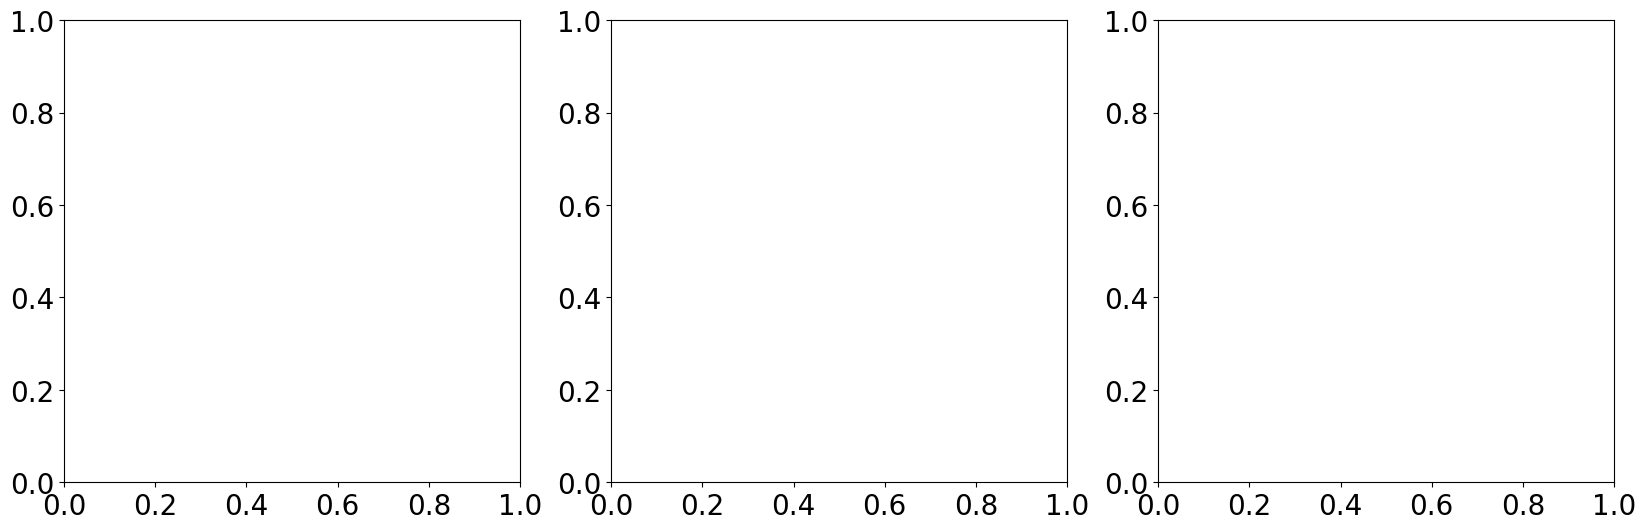

In [59]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)
#plt.rcParams['text.usetex'] = True

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature AE
feature_data = df[df['Feature'] == 'AE']

# Separate data by dataset
datasets = ['Synthetic', 'PinMNIST', 'Building']
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "."]
labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[0.969, 0.452, 0.405, 0.388], [-0.576, 0.607, -200.553, 0.546], [-0.271, -0.029, -0.202, -0.0958]] #-0.113 -0.032

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(20, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    if dataset != 'Building':
        mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
        mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    else:
        mode_npins_combinations = [('mesh', 16), ('mesh', 121), ('random', 10), ('random', 100)]
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    if dataset == 'Building':
        dataset = 'Rotterdam'
    ax.set_title(f'{dataset} - AE Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 1:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("AE_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

font = {'size': 20}
matplotlib.rc('font', **font)

# Assuming 'df' is your DataFrame, ensure it's correctly loaded or defined above this block
# Filter data for the feature DDPM
feature_data = df[df['Feature'] == 'DDPM']

# Separate data by dataset
datasets = ['Synthetic', 'PinMNIST']
colors = ["#56CCF2", "#EB5757", "#333333", "#F2C94C"]
patterns = [None, None, "x", "x"] #["/", "\\", "x", "x"]

# Assuming 'r2_nps' is correctly defined as per your context
r2_nps = [[0.969, 0.452, 0.405, 0.388], [-0.576, 0.607, -200.553, 0.546], [-0.271, -0.029, -0.202, -0.0958]] #-0.113 -0.032

labels = ["grid\nsparse", "grid\ndense", "random\nsparse", "random\ndense"]
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(datasets), figsize=(14, 6))

for i, (ax, dataset) in enumerate(zip(axes, datasets)):
    dataset_data = feature_data[feature_data['Dataset'] == dataset]
    
    if dataset != 'Building':
        mode_npins_combinations = dataset_data.groupby(['Mode', 'NPins']).size().index.tolist()
        mode_npins_combinations = sorted(mode_npins_combinations, key=lambda x: (x[0], x[1]))
    else:
        mode_npins_combinations = [('mesh', 16), ('mesh', 121), ('random', 10), ('random', 100)]
    
    #labels = [f"random\n{npins}" if mode == 'random' else f"grid\n{npins}" for mode, npins in mode_npins_combinations]
    x = np.arange(len(labels))  # the label locations
    
    width = 0.22  # Decreased width for slight whitespace between bars
    
    # Assuming these lists are populated correctly from your dataset
    r2_mse = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 MSE'].values[0] for mode, npins in mode_npins_combinations]
    r2_npp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 NPP'].values[0] for mode, npins in mode_npins_combinations]
    r2_gp = [dataset_data[(dataset_data['Mode'] == mode) & (dataset_data['NPins'] == npins) & (dataset_data['Partial Percent'] == 1.0)]['R2 GP'].values[0] for mode, npins in mode_npins_combinations]
    r2_np = r2_nps[i]
    
    # Adjusted positions for a small whitespace between bars
    rects1 = ax.bar(x - 1.5*width, r2_mse, width, label='Plain', color=colors[0], hatch=patterns[0], zorder=3)
    rects2 = ax.bar(x - 0.5*width, r2_npp, width, label='NPP', color=colors[1], hatch=patterns[1], zorder=3)
    rects3 = ax.bar(x + 0.5*width, r2_gp, width, label='NPP-GP', color=colors[2], hatch=patterns[2], edgecolor='#FFFFFF', zorder=3)
    rects4 = ax.bar(x + 1.5*width, r2_np, width, label='NP', color=colors[3], hatch=patterns[3], zorder=3)

    ax.set_ylabel('$R^2$ Coefficients')
    ax.set_title(f'{dataset} - DDPM Feature')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(True, which='major', linestyle='--', linewidth='0.5', color='grey')
    if i == 1:
        ax.set_ylim([-1, 1.05])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)
fig.suptitle('$R^2$ analysis for different densities')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("DDPM_barplot_pp1.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()


In [ ]:
# NP Results need to be inputted manually
Synthetic_NP = {
 "mesh_sparse": [0.969, 0.971, 0.972, 0.969],  # Grid Sparse
 "mesh_dense": [0.408, 0.440, 0.448, 0.452],   # Grid Dense
 "random_sparse": [0.418, 0.412, 0.416, 0.405], # Random Sparse
 "random_dense": [0.306, 0.357, 0.385, 0.388]   # Random Dense
}

PinMNIST_NP = {
 "mesh_sparse": [-0.576, -0.577, -0.576, -0.576],  # Grid Sparse
 "mesh_dense": [0.535, 0.580, 0.600, 0.607],       # Grid Dense
 "random_sparse": [-125.973, -131.527, -252.488, -200.553], # Random Sparse
 "random_dense": [0.459, 0.518, 0.534, 0.546]               # Random Dense
}

Rotterdam_NP = {
 "mesh_sparse": [-0.326, -0.245, -0.270, -0.271],  # Grid Sparse
 "mesh_dense": [-0.134, -0.059, -0.031, -0.029],  # Grid Dense
 "mesh_ultradense": [-0.201, -0.128, -0.121, -0.113],  # Grid Ultradense
 "random_sparse": [-0.200, -0.203, -0.211, -0.202], # Random Sparse
 "random_dense": [-0.121, -0.102, -0.101, -0.096], # Random Dense
 "random_ultradense": [-0.057, -0.041, -0.034, -0.032] # Random Ultradense
}

NP = [Synthetic_NP, PinMNIST_NP, Rotterdam_NP]


In [ ]:
x = [0.25, 0.50, 0.75, 1.00]

Rotterdam_NPP_GP = {
 "mesh_sparse": [0.248, 0.248, 0.248, 0.248],  # Grid Sparse
 "mesh_dense": [0.211, 0.211, 0.211, 0.211],  # Grid Dense
 "mesh_ultradense": [0.174, 0.174, 0.174, 0.174],   # Grid Ultradense
 "random_sparse": [0.126, 0.121, 0.108, 0.099], # Random Sparse
 "random_dense": [0.251, 0.255, 0.256, 0.261], # Random Dense
 "random_ultradense": [0.132, 0.142, 0.162, 0.178]  # Random Ultradense
}

NPP_GP = [None, None, Rotterdam_NPP_GP]


In [ ]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'AE')]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP']
data_names = ['Plain', 'NPP']
datasets = ['Synthetic', 'PinMNIST', 'Building']
modes = ['random'] #df_ae['Mode'].unique()
npins = [10] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(19, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric, only_GP = False):
    if not only_GP:       
        if k == 2 and modes[0] == 'mesh':
            if npins[0] == 9:
                npins[0] = 16
            if npins[0] == 100:
                npins[0] = 121
        for mode_idx, mode in enumerate(modes):
            for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
                for data_group_idx, data_group in enumerate(data_groups):
                    # Filter the dataset for the specific conditions
                    df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                        (df_ae['NPins'] == npins_value)]
                    if df_filtered.empty:
                        print('HEY')
                    label = data_names[data_group_idx]
                    color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                    linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                    marker =  markers[data_group_idx] #markers[data_group_idx]
                    value = df_filtered[df_filtered['Partial Percent'] == 1.0][data_group].values[0] if metric == 'MSE' else df_filtered[df_filtered['Partial Percent'] == 1.0][f'R2 {data_group}'].values[0]
                    ax.plot(x, [value]*len(x),
                            label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
        if k == 2:
            ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                            label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
        else:
            df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                        (df_ae['NPins'] == npins_value)]
            ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                            label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)



        ax.plot(x, NP[j][f"{modes[0]}_{density}"],
                            label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=4)
    else:
        if k == 2 and modes[0] == 'mesh':
            if npins[0] == 9:
                npins[0] = 16
            if npins[0] == 100:
                npins[0] = 121
        for mode_idx, mode in enumerate(modes):
            for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
                for data_group_idx, data_group in enumerate(data_groups):
                    if k == 2:
                        ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
                    else:
                        df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                                    (df_ae['NPins'] == npins_value)]
                        ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)

# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if j == 1:
    #    axs[j].set_ylim([0.92, 0.96])
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)
    # Add the zoom-in subplot for the second dataset (PinMNIST)
    if j == 1:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.25, 0.45, 0.70, 0.40])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0], False)
        inset_ax.set_ylim([0.9950, 0.99585])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)
    if j == 0:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.35, 0.35, 0.60, 0.30])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.5526, 0.5532])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
fig.suptitle(f'$R^2$  analysis for {mode_name} and {density}')
plt.tight_layout()
plt.savefig(f"AE_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

In [ ]:
# Correcting the variable naming conflict and trying again
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

font = {'size': 20}

matplotlib.rc('font', **font)

# Filter the DataFrame for rows where Feature is equal to "AE"
df_ae = df[(df['Feature'] == 'DDPM')]

# Settings for visualization
metrics = ['R2']
data_groups = ['MSE', 'NPP']
data_names = ['Plain', 'NPP']
datasets = ['Synthetic', 'PinMNIST']
modes = ['random'] #df_ae['Mode'].unique()
npins = [100] #df_ae['NPins'].unique()
mode_name = 'random' if modes[0] == 'random' else 'grid'
density = 'dense' if npins[0] == 100 else 'sparse'
#colors = sns.color_palette("tab10", n_colors=len(modes)*len(npins))
colors= ["#56CCF2", "#EB5757", "#333333", "#F2C94C"] #["#56CCF2", None, "#EB5757", None, "#333333", "#F2C94C"]
linestyles = ['-', '--', ':', '-.']
markers = ['o', 's', '^', 'P']
fig, axs = plt.subplots(len(metrics), len(datasets), figsize=(14, 6), sharex=True)
# Function to plot the lines, with fixed variable naming
def plot_lines(ax, k, metric):
    if k == 2 and modes[0] == 'mesh':
        if npins[0] == 9:
            npins[0] = 16
        if npins[0] == 100:
            npins[0] = 121
    for mode_idx, mode in enumerate(modes):
        for npins_idx, npins_value in enumerate(sorted(npins)):  # Corrected variable name here
            for data_group_idx, data_group in enumerate(data_groups):
                # Filter the dataset for the specific conditions
                df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
                if df_filtered.empty:
                    print('HEY')
                label = data_names[data_group_idx]
                color = colors[data_group_idx] #colors[mode_idx * len(npins) + list(sorted(npins)).index(npins_value)]
                linestyle = linestyles[data_group_idx] #linestyles[data_group_idx]
                marker =  markers[data_group_idx] #markers[data_group_idx]
                value = df_filtered[df_filtered['Partial Percent'] == 1.0][data_group].values[0] if metric == 'MSE' else df_filtered[df_filtered['Partial Percent'] == 1.0][f'R2 {data_group}'].values[0]
                ax.plot(x, [value]*len(x),
                        label=label, color=color, linestyle=linestyle, marker=marker, markersize=12, linewidth=3)
    if k == 2:
        ax.plot(x, NPP_GP[j][f"{modes[0]}_{density}"],
                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)
    else:
        df_filtered = df_ae[(df_ae['Dataset'] == datasets[k]) & (df_ae['Mode'] == mode) &
                                    (df_ae['NPins'] == npins_value)]
        ax.plot(df_filtered[df_filtered['Partial Percent'] != 0.0]['Partial Percent'], df_filtered[df_filtered['Partial Percent'] != 0.0][f'R2 GP'],
                        label="NPP-GP", color=colors[2], linestyle=linestyles[2], marker=markers[2], markersize=12, linewidth=3)

        
        
    ax.plot(x, NP[j][f"{modes[0]}_{density}"],
                        label="NP", color=colors[3], linestyle=linestyles[3], marker=markers[3], markersize=12, linewidth=4)
# Re-plotting for each subplot with the corrected function

for j, dataset in enumerate(datasets):
    plot_lines(axs[j], j, metrics[0])
    #if j == 1:
    #    axs[j].set_ylim([0.92, 0.96])
    axs[j].set_title(f'{dataset} - $R^2$')
    axs[j].set_xlabel('Partial Percent')
    axs[j].set_ylabel('$R^2$')
    #axs[j].set_ylim([-1.1,1.1])
    axs[j].set_xticks([0.25, 0.50, 0.75, 1.00])
    #axs[i, j].legend(loc='best', fontsize='small')
    axs[j].grid(True)
    # Add the zoom-in subplot for the second dataset (PinMNIST)
    if j == 0:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.31, 0.19, 0.65, 0.30])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.640, 0.645])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)
    if j == 5:  # Assuming PinMNIST is the second dataset
        # Set the limits for the zoomed-in area
        #axs[j].set_ylim([0.93, 0.97])
        
        # Create a new inset subplot with a zoomed view
        inset_ax = axs[j].inset_axes([0.3, 0.35, 0.65, 0.30])  # [x, y, width, height] in fractions of figure width and height
        plot_lines(inset_ax, j, metrics[0])
        inset_ax.set_ylim([0.5526, 0.5532])
        inset_ax.set_xticks([0.25, 0.50, 0.75, 1.00])
        inset_ax.grid(True)

handles, labels = axs[0].get_legend_handles_labels()

# Placing a global legend below the subplots
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize='small')
fig.suptitle(f'$R^2$  analysis for {mode_name} and {density} with DDPM extracted features')
plt.tight_layout()
plt.savefig(f"DDPM_Results_{mode_name}_{density}.pdf", format="pdf", bbox_inches="tight", transparent=True)
plt.show()

## TESTING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from tools.plot_utils import plot_and_save
from tools.data_utils import *
from tools.losses import NPPLoss
from tools.models import Autoencoder
from tools.optimization import EarlyStoppingCallback, evaluate_model
import matplotlib.pyplot as plt
import argparse
import time
from tools.models import *

experiment_id = "1709622898" # 1709521764
experiment_folder = "./history/exp_def"
dataset = "Synthetic"
feature = "DDPM"
mode = "random"
feature_extracted = True if feature == "DDPM" else False
mesh = True if mode == "mesh" else False
d = 3
n_pins = 100
partial_percent = 0.25
r = 3
batch_size = 32

num_kernels_encoder = [32, 16]
num_kernels_decoder = [32]


# Set a random seed for PyTorch
seed = 4  # You can use any integer value as the seed
torch.manual_seed(seed)
# Set a random seed for NumPy (if you're using NumPy operations)
np.random.seed(seed)

if dataset == "Synthetic":
    if feature_extracted:
        input_channel = 74
    else:
        input_channel = 3
elif dataset == "PinMNIST":
    if feature_extracted:
        input_channel = 71
    else:
        input_channel = 1
elif dataset == "Building":
    if feature_extracted:
        input_channel = 3584
    else:
        input_channel = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if feature_extracted:
    folder = f"{dataset}_ddpm"
else:
    folder = f"{dataset}"

if dataset == "PinMNIST":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_{28}by{28}pixels_{r}radius_{seed}seed"
    else:
        data_folder = f"./data/{folder}/random_fixedTrue_{n_pins}pins_{28}by{28}pixels_{r}radius_{seed}seed"
elif dataset == "Synthetic":
    folder += "/28by28pixels_1000images_123456seed"
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}step_pins"
    else:
        data_folder = f"./data/{folder}/random_{n_pins}pins"
elif dataset == "Building":
    if mesh:
        data_folder = f"./data/{folder}/mesh_{d}_step"
    else:
        data_folder = f"./data/{folder}/random_n_pins_{n_pins}"

if dataset == "Building":
    transform = transforms.Compose([
    ToTensor(),  # Convert to tensor (as you were doing)
    Resize100(),  # Resize to 100x100
])
else:
    transform = transforms.Compose([
    ToTensor(),  # Convert to tensor (as you were doing)
    Resize()  # Resize to 100x100
])

transformed_dataset = PinDataset(csv_file=f"{data_folder}/pins.csv",
                                      root_dir=f"./data/{folder}/images/",
                                      transform=transform)

dataset_size = len(transformed_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.10 * dataset_size)
test_size = dataset_size - train_size - val_size

# Split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(
    transformed_dataset, [train_size, val_size, test_size]
)

# Create your DataLoader with the custom_collate_fn
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)        

In [ ]:
# Testing
dataloader = train_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
experiment_id = 1709000615
dataloader = test_loader

if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth', map_location=device))
        autoencoder_MSE.eval()
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth', map_location=device))
        autoencoder_NPP.eval()
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")

        
hidden_samples = 0.5
for model in [autoencoder_MSE, autoencoder_NPP]:
    total_loss = 0.0
    criterion = NPPLoss(identity=True).to(device)

    with torch.no_grad():
        for batch in dataloader:
            x_test = batch['image'][:, :input_channel, :, :].to(device)
            p_test = [tensor.to(device) for tensor in batch['pins']]
            y_test = [tensor.to(device) for tensor in batch['outputs']]
            test_outputs = model(x_test.float())

            for i in range(len(x_test)):      
                num_samples = int(len(p_test[i]) * hidden_samples)
                p_sample = p_test[i][num_samples:]
                y_sample = y_test[i][num_samples:]
                mu_sample = (test_outputs[i].squeeze())[p_sample[:, 0], p_sample[:, 1]]
                if i == 0:
                    print('GT: ', y_sample)
                    print('OUTPUT: ', mu_sample)
            loss = criterion(y_test, test_outputs, p_test)

            total_loss += loss.item()

    total_loss /= len(dataloader)
    print('TEST LOSS: ', total_loss, '\n\n\n\n')

In [ ]:
# Testing
if not os.path.exists(f'{experiment_folder}/{experiment_id}'):
    raise Exception(f"Could not find experiment with id: {experiment_id}")
else:
    autoencoder_MSE = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    autoencoder_NPP = Autoencoder(num_kernels_encoder, num_kernels_decoder, input_channel=input_channel).to(device)
    # Load models
    try:
        autoencoder_MSE.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_MSE.pth'))
        autoencoder_NPP.load_state_dict(torch.load(f'{experiment_folder}/{experiment_id}/best_model_NPP.pth'))
    except:
        raise Exception("The model you provided does not correspond with the selected architecture. Please revise and try again.")
    # NPP
    for percent in [0.25, 0.50, 0.75, 1.00]:
        print(f'Percent testing {percent}')
        best_MSE_test_loss = evaluate_model(autoencoder_MSE, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=False, partial_percent=percent)
        try:
            GP_best_NPP_test_loss = evaluate_model(autoencoder_NPP, test_loader, input_channel, device, partial_label_GP=True, partial_percent=percent)
            # Write output into file
            filename = f"test_{folder.split('/')[0]}_{percent}.txt"
            with open(f"{experiment_folder}/{experiment_id}/{filename}", "w") as f:
                f.write(f"MSE {best_MSE_test_loss}; NPP {best_NPP_test_loss}, {GP_best_NPP_test_loss} (GP)")
        except Exception as Error:
            print(Error)